In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import optuna

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torch.utils.mobile_optimizer import optimize_for_mobile

In [3]:
df = pd.read_csv('sample_data/final_df_activity_v2.csv')
df

,gyro_x,gyro_y,gyro_z,acceleration_x,acceleration_y,acceleration_z,target
0,181,-3007,2892,5,-7,-2,0
1,185,-3010,2878,6,-7,-2,0
2,187,-3012,2892,6,-7,-2,0
3,186,-3009,2887,6,-7,-2,0
4,184,-3011,2888,6,-7,-2,0
...,...,...,...,...,...,...,...
52831,-4116,-1226,746,-174,-183,34,2
52832,-3750,-1417,789,-325,-36,-87,2
52833,-3811,-1375,806,311,90,-139,2
52834,-3775,-1227,902,19,34,62,2


<Axes: xlabel='target', ylabel='Count'>

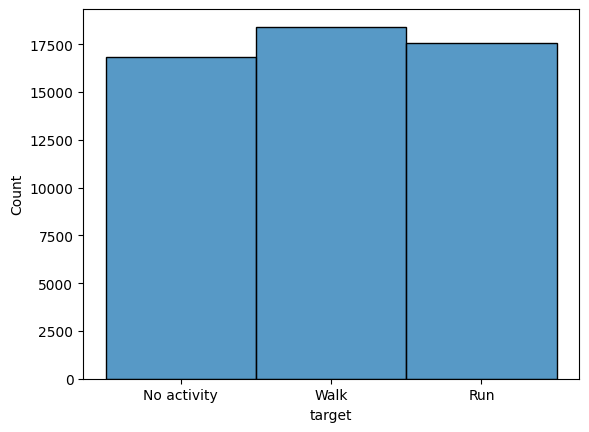

In [4]:
stat_df = deepcopy(df)
stat_df['target'] = stat_df['target'].replace([0, 1, 2], ['No activity', 'Walk', 'Run'])

sns.histplot(stat_df['target'])

In [5]:
X = df.drop(columns = ['target'])
y = df['target']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state = 42, 
                                                    shuffle = True)

X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size = 0.25,
                                                  shuffle = True)

In [7]:
class Data(Dataset):
  def __init__(self, X_train, y_train):
    self.X = torch.from_numpy(X_train.astype(np.float32))
    self.y = torch.from_numpy(y_train).type(torch.LongTensor)
    self.len = self.X.shape[0]
  
  def __getitem__(self, index):
    return self.X[index], self.y[index]
    
  def __len__(self):
    return self.len

In [8]:
EPOCHS = 10
BATCH_SIZE = 64
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

In [9]:
train_data = Data(X_train.to_numpy(), y_train.to_numpy())
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)
test_data = Data(X_test.to_numpy(), y_test.to_numpy())
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)
val_data = Data(X_val.to_numpy(), y_val.to_numpy())
val_loader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [10]:
print(len(train_loader))

620


In [11]:
print(len(val_loader))

207


In [12]:
N_TRAIN_EXAMPLES = BATCH_SIZE * 600
N_VALID_EXAMPLES = BATCH_SIZE * 200

In [13]:
def define_model(trial):
    n_layers = trial.suggest_int("n_layers", 1, 6)
    layers = []
    in_features = 6

    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float("dropout_l{}".format(i), 0.1, 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, 3))

    return nn.Sequential(*layers)

In [14]:
def objective(trial):
    model = define_model(trial).to(DEVICE)

    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log = True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr = lr)

    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            if batch_idx * BATCH_SIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.to(DEVICE), target.to(DEVICE)

            output = model(data)
            loss = criterion(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_loader):
                if batch_idx * BATCH_SIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                pred = output.argmax(dim = 1, keepdim = True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(val_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [15]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100, timeout = 600)

[I 2023-06-05 17:35:50,917] A new study created in memory with name: no-name-41ab4c56-0b96-4842-b34f-c08425f868b6
[I 2023-06-05 17:36:21,692] Trial 0 finished with value: 0.762265625 and parameters: {'n_layers': 3, 'n_units_l0': 36, 'dropout_l0': 0.4956092086629994, 'n_units_l1': 80, 'dropout_l1': 0.4698261889690153, 'n_units_l2': 126, 'dropout_l2': 0.2296605167397816, 'optimizer': 'RMSprop', 'lr': 0.003961921959257954}. Best is trial 0 with value: 0.762265625.
[I 2023-06-05 17:36:45,091] Trial 1 finished with value: 0.33171875 and parameters: {'n_layers': 3, 'n_units_l0': 97, 'dropout_l0': 0.20196999943993005, 'n_units_l1': 128, 'dropout_l1': 0.11375471356886586, 'n_units_l2': 34, 'dropout_l2': 0.31314838217143925, 'optimizer': 'RMSprop', 'lr': 0.01386474721901151}. Best is trial 0 with value: 0.762265625.
[I 2023-06-05 17:37:05,895] Trial 2 finished with value: 0.738828125 and parameters: {'n_layers': 1, 'n_units_l0': 53, 'dropout_l0': 0.4171885240843385, 'optimizer': 'Adam', 'lr': 0

In [16]:
optuna.visualization.plot_optimization_history(study)

In [17]:
optuna.visualization.plot_param_importances(study)

In [18]:
study.best_params

{'n_layers': 1,
 'n_units_l0': 84,
 'dropout_l0': 0.14510440203332323,
 'optimizer': 'RMSprop',
 'lr': 0.00046113607669243936}

In [19]:
INPUT_DIM = 6
HIDDEN_LAYERS = 84

OUTPUT_DIM = 3
criterion = nn.CrossEntropyLoss()

In [24]:
class NN_optuna(nn.Module):
  def __init__(self):
    super(NN_optuna, self).__init__()
    self.linear1 = nn.Linear(INPUT_DIM, HIDDEN_LAYERS)
    self.dropout1 = nn.Dropout(0.1451)
    self.linear2 = nn.Linear(HIDDEN_LAYERS, OUTPUT_DIM)

  def forward(self, x):
    x = torch.relu(self.linear1(x))
    x = self.dropout1(x)
    x = self.linear2(x)
    return x

In [25]:
NN_optuna = NN_optuna().to(DEVICE)
print(NN_optuna)

NN_optuna(
  (linear1): Linear(in_features=6, out_features=84, bias=True)
  (dropout1): Dropout(p=0.1451, inplace=False)
  (linear2): Linear(in_features=84, out_features=3, bias=True)
)


In [26]:
optimizer = torch.optim.RMSprop(NN_optuna.parameters(), lr = 0.00046)

In [27]:
correct, total = 0, 0
list_pred, list_true = [], []

with torch.no_grad():
  for (X, y) in test_loader:
    X, y = X.to(DEVICE), y.to(DEVICE)

    output = NN_optuna(X)
    pred = output.argmax(dim = 1, keepdim = True)
    list_pred.append(pred.cpu().numpy())
    list_true.append(y.cpu().numpy())
    correct += pred.eq(y.view_as(pred)).sum().item()
accuracy = correct / len(test_loader.dataset)
print(f'Accuracy: {accuracy:>0.4f} %')

Accuracy: 0.3228 %


In [28]:
list_pred = np.concatenate(list_pred)
list_pred = np.hstack(list_pred).tolist()
list_true = np.concatenate(list_true)
list_true = np.hstack(list_true).tolist()

In [29]:
cm = confusion_matrix(list_pred, list_true)
cm

array([[4357, 4711, 5025],
       [ 641,  677,  149],
       [ 116,   93,   82]])

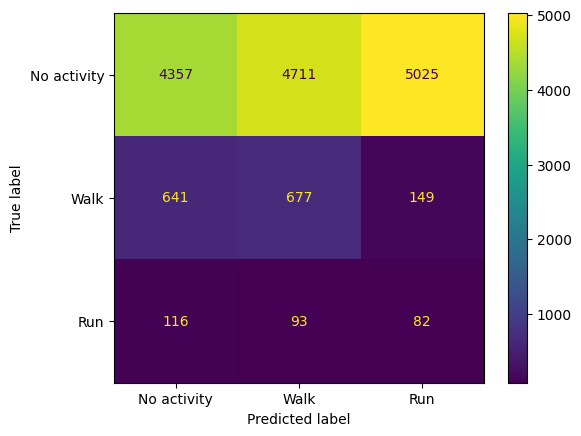

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['No activity', 'Walk', 'Run'])
disp.plot()